In [15]:
import numpy as np
import cv2
from numpy.lib.stride_tricks import as_strided
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt

In [16]:
#calculating sum squared difference from L to R
#x- strips in scanline
#t- strip in L
def ssd(x, t):
    tc = t.shape[1]
    xc = x.shape[1]
    #
    s = np.array([np.sum((t - x[:,int(i-tc/2):int(i+tc/2)]) ** 2)
                  for i in range(int(tc / 2)+1, int(xc - tc/2))], dtype=np.float32)
    # returning the ssd of all the strips
    return s[None,:]


## usind ssd as matching function
def disparity_ssd(L, R, block_size=5, disparity_range=30):
    """Compute disparity map D(y, x) such that: L(y, x) = R(y, x + D(y, x))
    Params:
    L: Grayscale left image
    R: Grayscale right image, same size as L
    Returns: Disparity map, same size as L, R
    """

    #Images are of same size
    im_rows, im_cols = L.shape
    tpl_rows = tpl_cols = block_size
    #new matrix initialization with zeros
    D_L = np.zeros(L.shape, dtype=np.float32)

    #iteration through rows
    for row in range(int(tpl_rows/2), int(im_rows-tpl_rows/2)):
        #min and max co-ordinates of rows in L and R - strip
        Lr_min = max(row-tpl_rows/2, 0)
        Lr_max=min(row+tpl_rows/2+1, im_rows)
        #iteration through columns
        for column in range(int(tpl_cols/2), int(im_cols-tpl_cols/2)):
            # min and max co-ordinates of cols in L - strip
            Lc_min = max(column-tpl_cols/2, 0)
            Lc_max = min(column+tpl_cols/2+1, im_cols)
            #crop the image according to min and max co-ordinates
            tpl = L[int(Lr_min):int(Lr_max), int(Lc_min):int(Lc_max)].astype(np.float32)
            # get R strip in a window with width=disparity_range
            #min and max co-ordinates of cols in R-strip
            Lc_min = max(column-disparity_range/2, 0)
            Lc_max = min(column+disparity_range/2+1, im_cols)
            #crop the image according to min and max co-ordinates
            R_strip = R[int(Lr_min):int(Lr_max), int(Lc_min):int(Lc_max)].astype(np.float32)
            #ssd results
            error = ssd(R_strip, tpl)  # slow
            c_Lf = max(column-Lc_min-tpl_cols/2, 0)
            #it returns evenly spaced values within a given interval(i.e error.shape[1])
            dist = np.arange(error.shape[1]) - c_Lf
            cost = error
            #MinMax funcion returns the maximum and minimum intensity values 
            _,_,min_loc,_ = cv2.minMaxLoc(cost)
            #storing these distances in the new image
            D_L[row, column] = dist[min_loc[0]]
    #returning the depth map
    return D_L

#find similarity using correlation
def disparity_ncorr(L, R, block_size=5, disparity_range=30):
    #Images are of same size
    im_rows, im_cols = L.shape
    tpl_rows = tpl_cols = block_size
    #initializing a new image with zeros
    D_L = np.zeros(L.shape, dtype=np.float32)

    #iterating through rows
    for row in range(int(tpl_rows/2), int(im_rows-tpl_rows/2)):
        #min and max co-ordinates of rows in L and R - strip
        Lr_min= max(row-tpl_rows/2, 0)
        Lr_max =min(row+tpl_rows/2+1, im_rows)
        #iterating through columns
        for column in range(int(tpl_cols/2), int(im_cols-tpl_cols/2)):
            # min and max co-ordinates of cols in L - strip
            Lc_min = max(column-tpl_cols/2, 0)
            Lc_max = min(column+tpl_cols/2+1, im_cols)
            #crop the image according to min and max co-ordinates
            tpl = L[int(Lr_min):int(Lr_max), int(Lc_min):int(Lc_max)].astype(np.float32)
            # get R strip in a window with width=disparity_range
            #min and max co-ordinates of cols in R-strip
            Lc_min = max(column-disparity_range/2, 0)
            Lc_max = min(column+disparity_range/2+1, im_cols)
            #crop the image according to min and max co-ordinates
            R_strip = R[int(Lr_min):int(Lr_max), int(Lc_min):int(Lc_max)].astype(np.float32)
            # find best match of template in strip
            error = cv2.matchTemplate(R_strip, tpl, method=cv2.TM_CCORR_NORMED)
            c_Lf = max(column-Lc_min-tpl_cols/2, 0)
            dist = np.arange(error.shape[1]) - c_Lf
            #print(dist)
            cost = error 
            #print(cost)
            _,_,_,max_loc = cv2.minMaxLoc(cost)
            D_L[row, column] = dist[max_loc[0]]
    #returning the depth map
    return D_L

<Figure size 432x288 with 0 Axes>

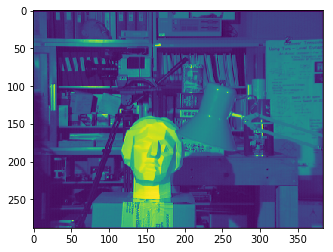

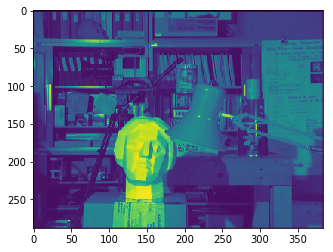

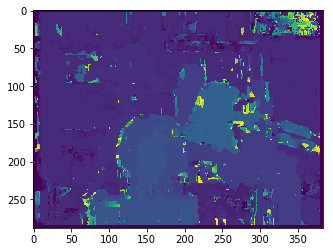

<Figure size 432x288 with 0 Axes>

In [17]:
#reading left image
L = cv2.imread('tsukuba1.ppm', cv2.IMREAD_GRAYSCALE)
plt.imshow(L)
plt.figure()
#reading right image
R = cv2.imread('tsukuba2.ppm', cv2.IMREAD_GRAYSCALE)
plt.imshow(R)
plt.figure()

#normalizing image not necessay
L = L * (1.0 / 255.0)
R = R * (1.0 / 255.0)

# compute disparity maps, dr= desparity range
window_size = 7; dr = 100

#normalized correlation as matching function
#D_L_1 = np.abs(disparity_ssd(L, R, block_size=window_size, disparity_range=dr))
D_L = np.abs(disparity_ncorr(L, R, block_size=window_size, disparity_range=dr))

plt.imshow(D_L)
plt.figure()


<Figure size 432x288 with 0 Axes>

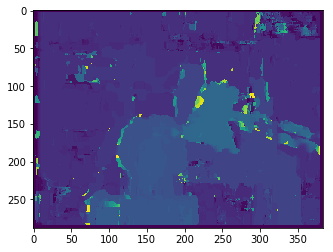

<Figure size 432x288 with 0 Axes>

In [18]:
#sum squared distance as matching function
D_L_1 = np.abs(disparity_ssd(L, R, block_size=window_size, disparity_range=dr))

plt.imshow(D_L_1)
plt.figure()